In [ ]:
#接下来是分水岭环节


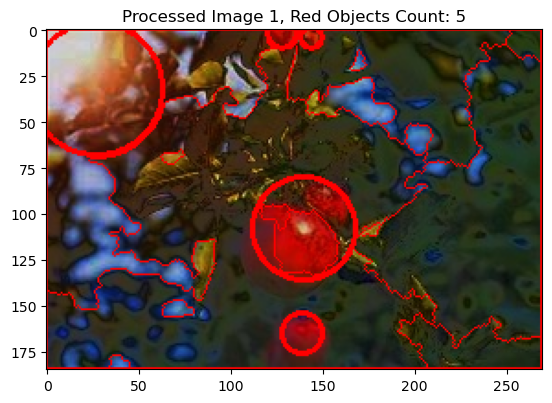

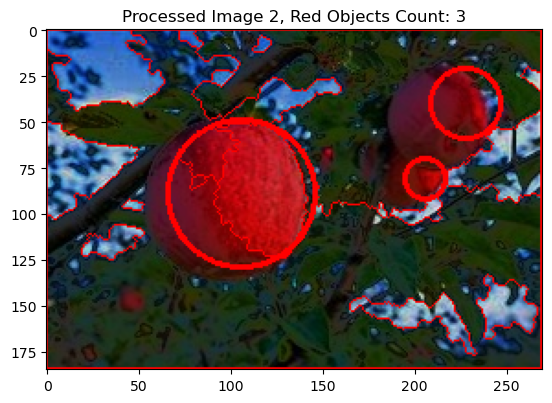

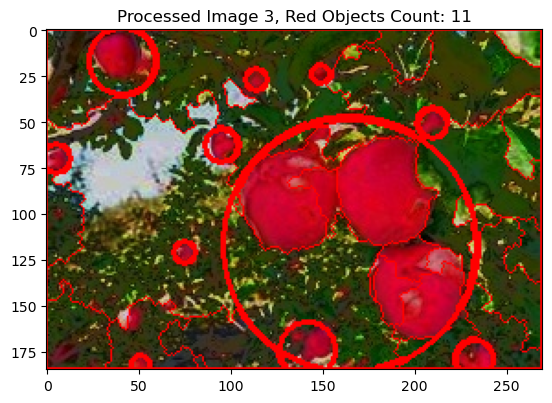

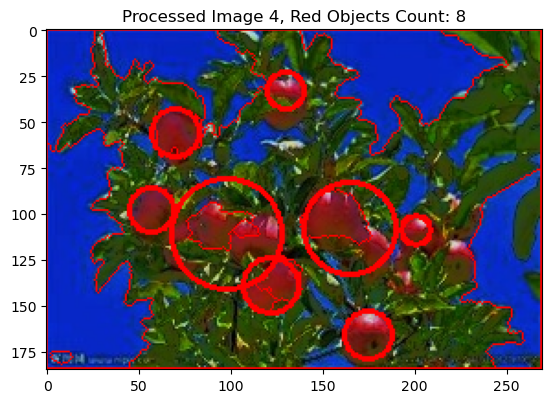

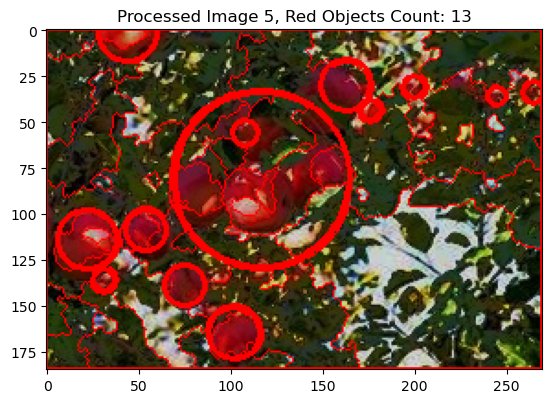

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#这段代码实现的是使用分水岭后的结果
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图片
def ReadImg(image_path):
    img = cv2.imread(image_path, 1)
    return img

# 高斯滤波
def GausBlur(src):
    dst = cv2.GaussianBlur(src, (5, 5), 1.5)
    return dst

# 开运算（替代 open_mor）
def open_mor(img):
    kernel = np.ones((5, 5), np.uint8)
    result = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return result

# 红色对象检测
def detect_red_objects(src):
    # 设定红色阈值范围
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([100, 100, 255])

    # 根据阈值构建掩模
    mask = cv2.inRange(src, lower_red, upper_red)

    # 使用掩模提取红色对象
    red_objects = cv2.bitwise_and(src, src, mask=mask)

    return red_objects

# 轮廓拟合
def draw_shape(open_img, src, markers):
    contours, hierarchy = cv2.findContours(open_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    apple_count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 50:  # 假设红色对象的最小面积为100
            # 获取圆心和半径
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)

            # 绘制圆形
            cv2.circle(src, center, radius, (0, 0, 255), 2)

            apple_count += 1

    return src, apple_count


def test_watershed(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), dtype=np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=2)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    cv2.normalize(dist_transform, dist_transform, 0, 1.0, cv2.NORM_MINMAX)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknow = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknow == 255] = 0
    markers_copy = markers.copy()

    markers = cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]

    return image

# Process all images
for i in range(1, 6):  # Assuming image numbers from 1 to 200
    image_path = f'Attachment_2/{i}_processed.jpg'
    src = ReadImg(image_path)
    gaus_img = GausBlur(src)
    red_objects_img = detect_red_objects(gaus_img)
    gray_img = cv2.cvtColor(red_objects_img, cv2.COLOR_BGR2GRAY)
    _, thres_img = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)
    open_img = open_mor(thres_img)

    sure_bg = cv2.dilate(open_img, None, iterations=3)
    dist_transform = cv2.distanceTransform(open_img, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(src, markers)

    src[markers == -1] = [0, 0, 255]

    result_img, apple_count = draw_shape(open_img, src, markers)

    # Apply watershed to the result
    result_with_watershed = test_watershed(result_img)

    # Display the processed image with watershed result
    plt.imshow(cv2.cvtColor(result_with_watershed, cv2.COLOR_BGR2RGB))
    plt.title(f'Processed Image {i}, Red Objects Count: {apple_count}')
    plt.show()

以上的代码仅仅实现了分割，但是并没有是对红色部分分割，所以效果很差
接下来我们要进行的是基于红色区域分割与识别


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图片
def ReadImg(image_path):
    img = cv2.imread(image_path, 1)
    return img

# 红色对象检测
def detect_red_objects(src):
    # 设定红色阈值范围
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([100, 100, 255])

    # 根据阈值构建掩模
    mask = cv2.inRange(src, lower_red, upper_red)

    # 使用掩模提取红色对象
    red_objects = cv2.bitwise_and(src, src, mask=mask)

    return red_objects

# 分水岭分割
def watershed_segmentation(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), dtype=np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=2)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    cv2.normalize(dist_transform, dist_transform, 0, 1.0, cv2.NORM_MINMAX)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    markers_copy = markers.copy()

    markers = cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]

    return image

# 读取并处理图像
for i in range(1, 6):  # Assuming image numbers from 1 to 200
    image_path = f'Attachment_2/{i}_processed.jpg'
    src = ReadImg(image_path)
    red_objects_img = detect_red_objects(src)

    # 进行分水岭分割
    result_with_watershed = watershed_segmentation(red_objects_img)

    # 统计红色对象数量
    contours, _ = cv2.findContours(result_with_watershed[:,:,2], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    red_objects_count = len(contours)

    # 显示结果
    plt.imshow(cv2.cvtColor(result_with_watershed, cv2.COLOR_BGR2RGB))
    plt.title(f'Processed Image {i}, Red Objects Count: {red_objects_count}')
    plt.show()

以上的代码，不知道为什么剩余部分都变成了黑色，生在的部分变成了红色，那么我们能不能基于这个代码把红色部分进一步区分与技术，并且与原图像重叠后呢？


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 读取图片
def ReadImg(image_path):
    img = cv2.imread(image_path, 1)
    return img

# 红色对象检测
def detect_red_objects(src):
    # 设定红色阈值范围
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([100, 100, 255])

    # 根据阈值构建掩模
    mask = cv2.inRange(src, lower_red, upper_red)

    # 使用掩模提取红色对象
    red_objects = cv2.bitwise_and(src, src, mask=mask)

    return red_objects

# 分水岭分割
def watershed_segmentation(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), dtype=np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=2)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    cv2.normalize(dist_transform, dist_transform, 0, 1.0, cv2.NORM_MINMAX)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    markers_copy = markers.copy()

    markers = cv2.watershed(image, markers)
    result = image.copy()
    result[markers == -1] = [0, 0, 255]

    return result

# 读取并处理图像
for i in range(1, 201):  # Assuming image numbers from 1 to 200
    image_path = f'Attachment_2/{i}_processed.jpg'
    src = ReadImg(image_path)
    red_objects_img = detect_red_objects(src)

    # 进行分水岭分割
    result_with_watershed = watershed_segmentation(red_objects_img)

    # 保存结果
    output_path = os.path.join(output_path, f'{i}_fenshui.jpg')
    cv2.imwrite(output_path, result_with_watershed)
    
    # 显示结果
    plt.imshow(cv2.cvtColor(result_with_watershed, cv2.COLOR_BGR2RGB))
    plt.title(f'Processed Image {i}')
    plt.show()

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# 读取图片
def ReadImg(image_path):
    img = cv2.imread(image_path, 1)
    return img

# 红色对象检测
def detect_red_objects(src):
    # 设定红色阈值范围
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([100, 100, 255])

    # 根据阈值构建掩模
    mask = cv2.inRange(src, lower_red, upper_red)

    # 使用掩模提取红色对象
    red_objects = cv2.bitwise_and(src, src, mask=mask)

    return red_objects

# 分水岭分割
def watershed_segmentation(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), dtype=np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=2)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    cv2.normalize(dist_transform, dist_transform, 0, 1.0, cv2.NORM_MINMAX)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    markers_copy = markers.copy()

    markers = cv2.watershed(image, markers)
    result = image.copy()
    result[markers == -1] = [0, 0, 255]

    return result

# 创建保存结果的文件夹
output_folder = 'Attachment_3'
os.makedirs(output_folder, exist_ok=True)

# 读取并处理图像
for i in range(1, 201):  # Assuming image numbers from 1 to 200
    image_path = f'Attachment_2/{i}_processed.jpg'
    src = ReadImg(image_path)
    red_objects_img = detect_red_objects(src)

    # 进行分水岭分割
    result_with_watershed = watershed_segmentation(red_objects_img)

    # 保存结果
    output_path = os.path.join(output_folder, f'{i}_result.jpg')
    cv2.imwrite(output_path, result_with_watershed)

    # 显示结果
    plt.imshow(cv2.cvtColor(result_with_watershed, cv2.COLOR_BGR2RGB))
    plt.title(f'Processed Image {i}')
    plt.show()

接下来用鸡蛋代码来计数

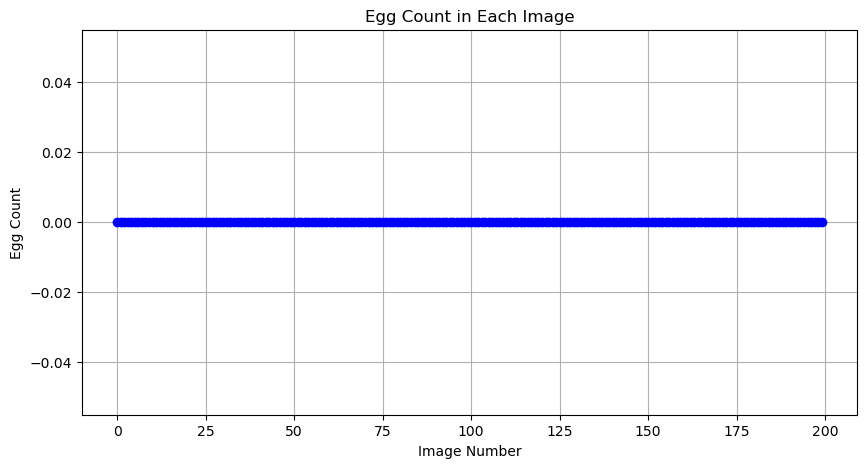

In [24]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def count_eggs_in_images(folder_path):
    egg_count_list = []
    images = os.listdir(folder_path)
    images.sort()  # 确保按顺序读取图像

    for image_file in images:
        image_path = os.path.join(folder_path, image_file)
        I = cv2.imread(image_path)
        I = cv2.resize(I, (500, 500))
        img_Guassian = cv2.GaussianBlur(I, (5, 5), 0)
        gray = cv2.cvtColor(img_Guassian, cv2.COLOR_BGR2GRAY)
        thre, bw = cv2.threshold(gray, 165, 255, cv2.THRESH_BINARY)
        kernel = np.ones((7, 7), np.uint8)
        opening = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)
        contours, _ = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        egg_count_list.append(len(contours))

    return egg_count_list

folder_path = r'Attachment_3'  # 替换为包含图像的文件夹路径
egg_count_list = count_eggs_in_images(folder_path)

# 绘制坐标图
plt.figure(figsize=(10, 5))
plt.plot(egg_count_list, marker='o', linestyle='-', color='b')
plt.xlabel('Image Number')
plt.ylabel('Egg Count')
plt.title('Egg Count in Each Image')
plt.grid(True)
plt.show()

In [1]:
import cv2
import numpy as np
I=cv2.imread ("Attachment_3/1_result.jpg") #这里输入绝对路径，读取图像
I=cv2.resize(I,(500,500)) #因为图片太大，所以改变了图片的大小
img_Guassian=cv2.GaussianBlur(I,(5,5),0)  #高斯滤波一下，去除图片中的噪声
gray=cv2.cvtColor(img_Guassian,cv2.COLOR_BGR2GRAY)  #灰度化图像
thre,bw=cv2.threshold(gray,165,255,cv2.THRESH_BINARY)  #对图片进行二值化操作，使图片只有黑色和白色
#二值化后，进行形态学操作（开运算，腐蚀+膨胀），去除细小干扰
kernel=np.ones((7,7),np.uint8)  #设置形态学操作卷积核大小
opening=cv2.morphologyEx(bw,cv2.MORPH_OPEN,kernel)
cv2.imshow('opening',opening)  #查看形态学操作后的结果并展示
#下面操作得到轮廓contours
contours,hir=cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) #opencv2.版本需要接收三个返回值
# 检测所有轮廓，所有轮廓建立一个等级树结构。外层轮廓包含内层轮廓，内层轮廓还可以继续包含内嵌轮廓。
sum=0  #sum记录鸡蛋个数
result = cv2.drawContours(I, contours, -1, (0, 255, 0), 3)  #利用得到的轮廓信息，将轮廓绘制出
str='the number of eggs: '+str(len(contours))  #想在图片上显示鸡蛋个数信息，这是需要显示的字符串
img=cv2.putText(result,str,(0,20),cv2.FONT_HERSHEY_TRIPLEX,0.6,(0,0,255),1)  #将文字显示到图片上
# print('鸡蛋个数为：',sum)
cv2.imshow('I',result)  #展示图片
cv2.waitKey(0)


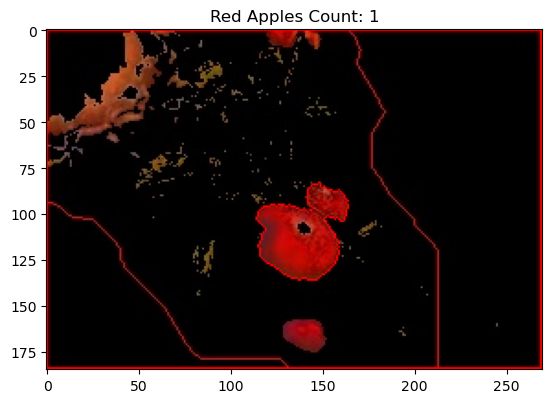

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def count_red_apples(image_path):
    # 读取图像
    img = cv2.imread(image_path)
    
    # 转换颜色空间 BGR 到 HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 定义红色苹果的颜色范围
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])

    # 创建掩膜
    mask = cv2.inRange(hsv, lower_red, upper_red)

    # 进行分水岭算法分割
    result = watershed_segmentation(img, mask)

    # 统计红色苹果区域的数量
    count = count_objects(result)

    return result, count

def watershed_segmentation(image, mask):
    # 对掩膜进行形态学操作，获取更好的分割结果
    kernel = np.ones((5, 5), np.uint8)
    sure_bg = cv2.dilate(mask, kernel, iterations=3)

    # 距离变换
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # 找到未知区域
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # 标记连通区域
    _, markers = cv2.connectedComponents(sure_fg)

    # 添加一个标签，使水域的标签为0
    markers = markers + 1
    markers[unknown == 255] = 0

    # 应用分水岭算法
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]

    return image

def count_objects(image):
    # 将图像转为灰度
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 二值化处理
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 绘制轮廓
    result = image.copy()
    cv2.drawContours(result, contours, -1, (0, 255, 0), 2)

    # 返回对象数量
    return len(contours)

# 图像路径
image_path = "Attachment_3/1_result.jpg"  # 替换为你的图像路径

# 计数红色苹果区域并显示结果
result_image, apple_count = count_red_apples(image_path)

# 显示结果
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title(f'Red Apples Count: {apple_count}')
plt.show()

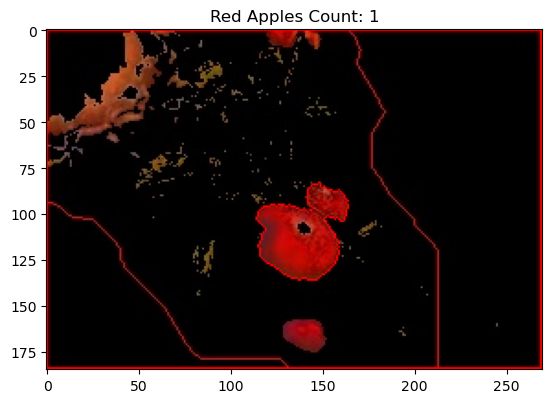

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def count_red_apples(image_path):
    # 读取图像
    img = cv2.imread(image_path)
    
    # 转换颜色空间 BGR 到 HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 定义红色苹果的颜色范围
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])

    # 创建掩膜
    mask = cv2.inRange(hsv, lower_red, upper_red)

    # 进行分水岭算法分割
    result = watershed_segmentation(img, mask)

    # 统计红色苹果区域的数量
    count = count_objects(result)

    return result, count

def watershed_segmentation(image, mask):
    # 对掩膜进行形态学操作，获取更好的分割结果
    kernel = np.ones((5, 5), np.uint8)
    sure_bg = cv2.dilate(mask, kernel, iterations=5)

    # 距离变换
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # 找到未知区域
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # 标记连通区域
    _, markers = cv2.connectedComponents(sure_fg)

    # 添加一个标签，使水域的标签为0
    markers = markers + 1
    markers[unknown == 255] = 0

    # 应用分水岭算法
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]

    return image

def count_objects(image):
    # 将图像转为灰度
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 二值化处理
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 绘制轮廓
    result = image.copy()
    cv2.drawContours(result, contours, -1, (0, 255, 0), 2)

    # 返回对象数量
    return len(contours)

# 图像路径
image_path = "Attachment_3/1_result.jpg"  # 替换为你的图像路径

# 计数红色苹果区域并显示结果
result_image, apple_count = count_red_apples(image_path)

# 显示结果
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title(f'Red Apples Count: {apple_count}')
plt.show()